In [2]:
# adds the project specific libs to the sys path
import sys
from pathlib import Path

proj_lib_path = str(Path.cwd().parent / 'libs')
if proj_lib_path not in sys.path:
    sys.path.insert(1, proj_lib_path)
    print(f'added {proj_lib_path} to the sys.path')

added /Users/n0c09jf/code/github/tryml/projects/binsense/libs to the sys.path


In [3]:
from binsense.config import MODEL_DIR, DATA_DIR
import os

print(f'models area at {MODEL_DIR}')
print(f'data is at {DATA_DIR}')

models area at /Users/n0c09jf/code/github/tryml/projects/binsense/_models
data is at /Users/n0c09jf/code/github/tryml/projects/binsense/_data


In [4]:
from binsense.config import BIN_DOWNLOAD_DIR
from binsense.config import DATA_DIR

from botocore import UNSIGNED
from botocore.config import Config
from tqdm import tqdm

import boto3, os

# TODO: download the unique_image_names.csv in a public location on 'gist'
#       configure the gist url in config
image_csv_path = os.path.join(DATA_DIR, 'unique_image_names.csv')
with open(image_csv_path, 'r') as f:
    image_names = f.readlines()[1:]
image_names = [x.strip() for x in image_names]

images_dir = os.path.join(BIN_DOWNLOAD_DIR, 'images')
meta_dir = os.path.join(BIN_DOWNLOAD_DIR, 'metadata')
os.makedirs(images_dir, exist_ok=True)
os.makedirs(meta_dir, exist_ok=True)

s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
for image_name in tqdm(image_names):
    image_name = image_name.strip()
    target_image_file = os.path.join(BIN_DOWNLOAD_DIR, 'images', f'{image_name}.jpg')
    target_metadata_file = os.path.join(BIN_DOWNLOAD_DIR, 'metadata', f'{image_name}.json')
    
    if not os.path.exists(target_image_file):
        with open(target_image_file, 'wb') as f:
            s3.download_fileobj('aft-vbi-pds', f'bin-images/{image_name}.jpg', f)
    
    if not os.path.exists(target_metadata_file):
        with open(target_metadata_file, 'wb') as f:
            s3.download_fileobj('aft-vbi-pds', f'metadata/{image_name}.json', f)

100%|██████████| 3875/3875 [00:00<00:00, 8965.36it/s]


In [5]:
from binsense.config import BIN_DOWNLOAD_DIR
from PIL import Image

import json, traceback
import pandas as pd


def default_on_none(dict_obj, hkeys, default_value=None):
        if dict_obj:
            obj = dict_obj
            for key in hkeys:
                if obj and key in obj.keys():
                    obj = obj[key]
                else:
                    return default_value
            return obj
        else:
            return default_value


bin_df = pd.DataFrame(columns=[
    'bin_id', 'bin_qty', 'bin_image_name', 
    'bin_image_kb', 'bin_image_width', 'bin_image_height'])
item_df = pd.DataFrame(columns=[
    'bin_id', 'item_id', 'item_name', 'item_qty',
    'item_length', 'item_length_unit', 
    'item_width', 'item_width_unit', 
    'item_height', 'item_height_unit', 
    'item_weight', 'item_weight_unit'])

for f_name in os.listdir(os.path.join(BIN_DOWNLOAD_DIR, 'metadata')):
    meta_path = os.path.join(BIN_DOWNLOAD_DIR, 'metadata', f_name)
    if not os.path.isfile(meta_path):
        continue

    with open(meta_path, 'r') as f:
        metadata = json.load(f)
    
    bin_id = f_name[0:f_name.rfind('.')]
    bin_qty = metadata['EXPECTED_QUANTITY']
    bin_image_name = f'{bin_id}.jpg'
    img_path = os.path.join(BIN_DOWNLOAD_DIR, 'images', bin_image_name)
    bin_img_kb = round(os.stat( img_path).st_size / 1024, 1)
    bin_img_width, bin_img_height = Image.open(img_path).size
    
    bin_df.loc[len(bin_df)] = [
        bin_id, bin_qty, bin_image_name,
        bin_img_kb, bin_img_width, bin_img_height]
    try:
        for item_id in metadata['BIN_FCSKU_DATA'].keys():
            item_dict = metadata['BIN_FCSKU_DATA'][item_id]
            item_name = default_on_none(item_dict, ['normalizedName'])
            item_name = item_name if item_name else default_on_none(item_dict, ['name'])
            item_df.loc[len(item_df)] = [
                bin_id,
                item_id, item_name, item_dict['quantity'],
                default_on_none(item_dict, ['length', 'value'], float("nan")), 
                default_on_none(item_dict, ['length', 'unit']),
                default_on_none(item_dict, ['width','value'], float("nan")), 
                default_on_none(item_dict, ['width', 'unit']),
                default_on_none(item_dict, ['height', 'value'], float("nan")), 
                default_on_none(item_dict, ['height', 'unit']),
                default_on_none(item_dict, ['weight','value'], float("nan")), 
                default_on_none(item_dict, ['weight', 'unit'])]
    except Exception as e:
        traceback.print_exc() 
        print(bin_id, e)

In [6]:
len(bin_df)

3875

In [7]:
bin_df.describe()

bin_qty  bin_image_kb  bin_image_width  bin_image_height
count  3875.000000   3875.000000      3875.000000       3875.000000
mean      4.600516     67.434994       521.530839        477.536516
std       3.553035     34.224032       112.719219        201.815852
min       1.000000     15.100000       304.000000        228.000000
25%       3.000000     39.200000       412.500000        308.000000
50%       4.000000     60.300000       526.000000        467.000000
75%       5.000000     87.050000       611.000000        580.000000
max      50.000000    240.400000       865.000000       1179.000000

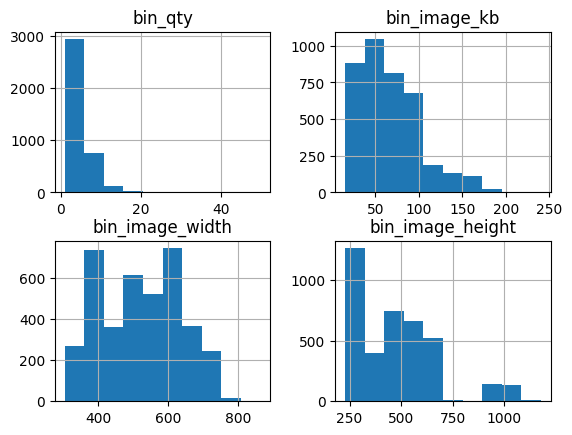

In [8]:
axarr = bin_df[['bin_qty', 'bin_image_kb', 'bin_image_width', 'bin_image_height']].hist()

array([[<Axes: title={'center': 'item_qty'}>]], dtype=object)

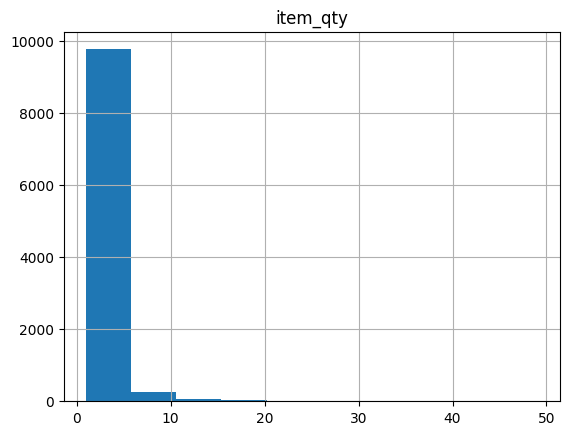

In [9]:
item_df[['item_qty']].hist()

## Distribution of item classes in bins
Out of 3875 bins
- ~400 bins have 1 item class
- ~1400 bins have 2 item classes
- ~1400 bins have 3 item classes
- ~600 bins have 4 item classes

item_classes
count   3875.000000
mean       2.617806
std        0.878965
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        4.000000

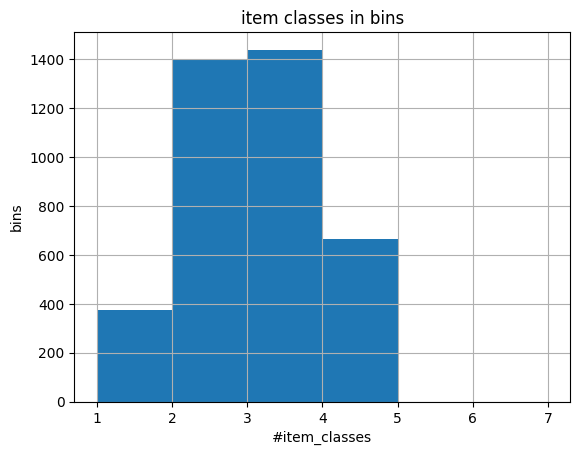

In [10]:
#print("number of item classes", item_df['bin_id'].nunique())
df = item_df.groupby(['bin_id'])['item_id'].count().reset_index(name="item_classes")
ax = df['item_classes'].hist(bins=range(1,8,1))
ax.set_xlabel("#item_classes")
ax.set_ylabel("bins")
ax.set_title("item classes in bins")
df.describe()

## Distribution of item classes across bins
Out of 5280 item classes
- ~2500 item classes exist in only 1 bin
- ~1000 in 2 bins
- ~1750 in 3 bins
- and few in 4+ bins

bins
count  5280.000000
mean      1.921212
std       0.987056
min       1.000000
25%       1.000000
50%       2.000000
75%       3.000000
max      13.000000

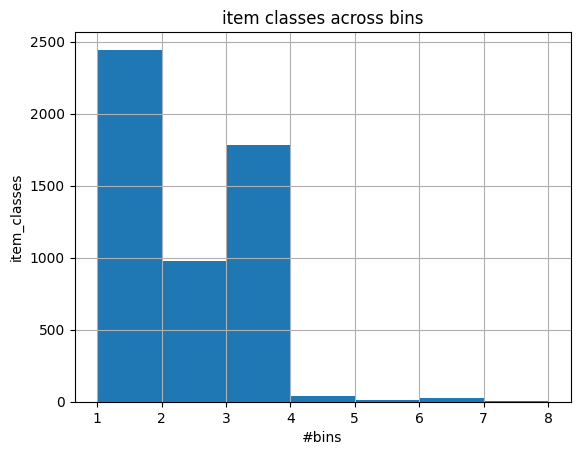

In [11]:
df = item_df.groupby(['item_id'])['bin_id'].count().reset_index(name="bins")
ax = df['bins'].hist(bins=range(1,9,1))
ax.set_xlabel("#bins")
ax.set_ylabel("item_classes")
ax.set_title("item classes across bins")
df.describe()

## Compare the items in different bins with different qty, weight, height/width/length
- 416 item classes have different qty across bins
- ~35 item classes have different weight,height,width,length (rounded to 2 decimals) across bins with or without same quantity across bins.  

items with different qty in bins  416


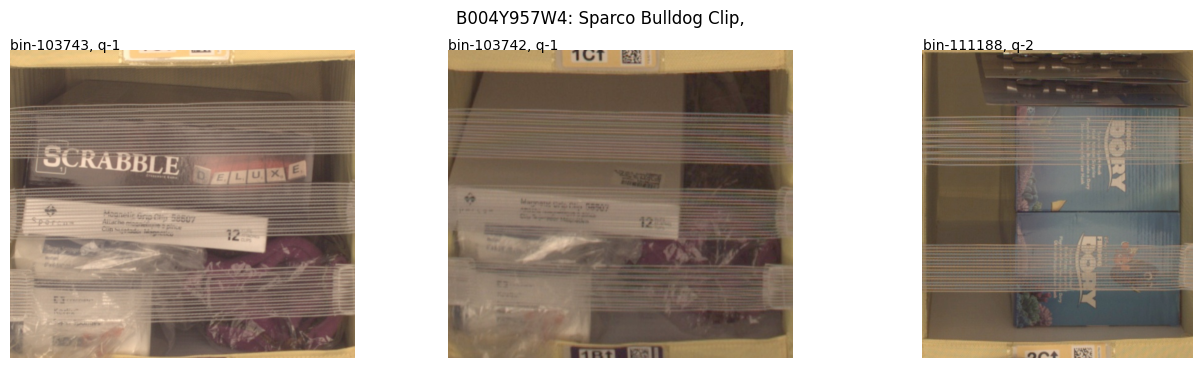

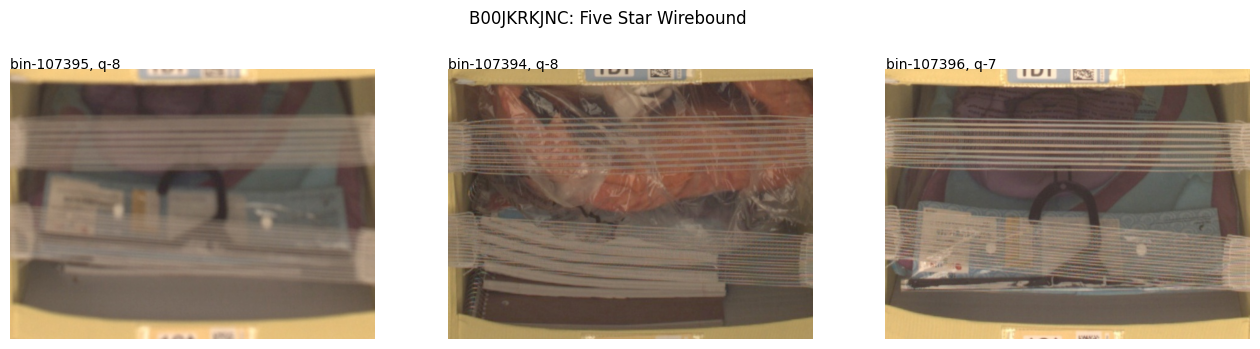

items with different weight in bins  37


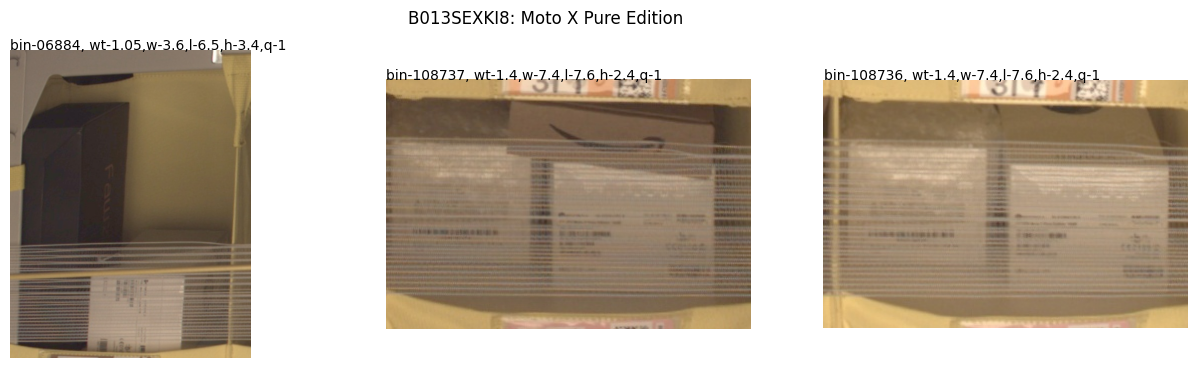

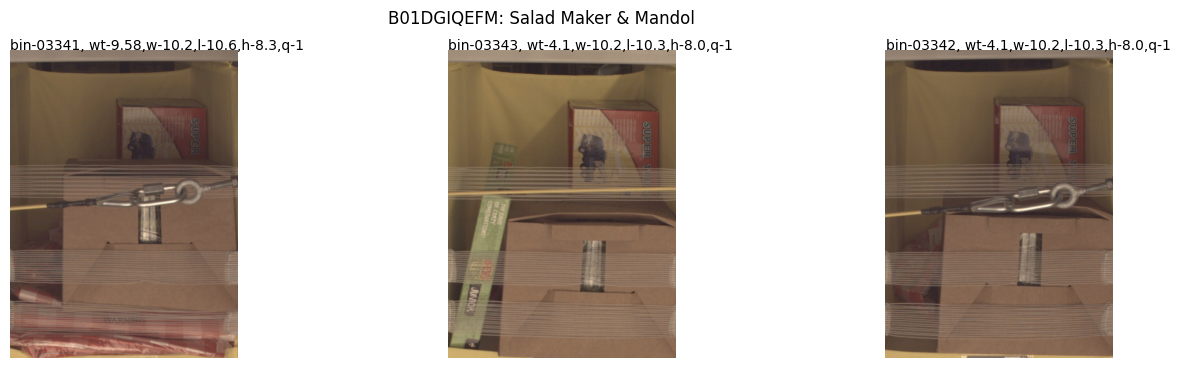

items with different height in bins  35


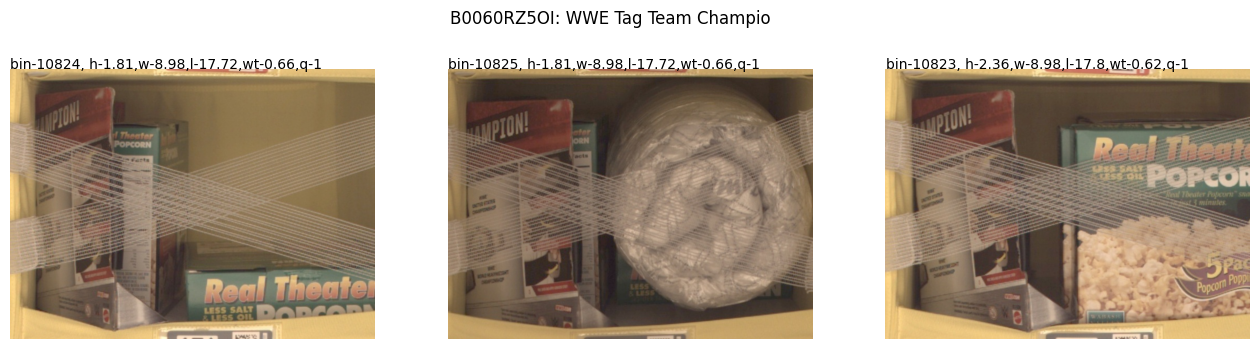

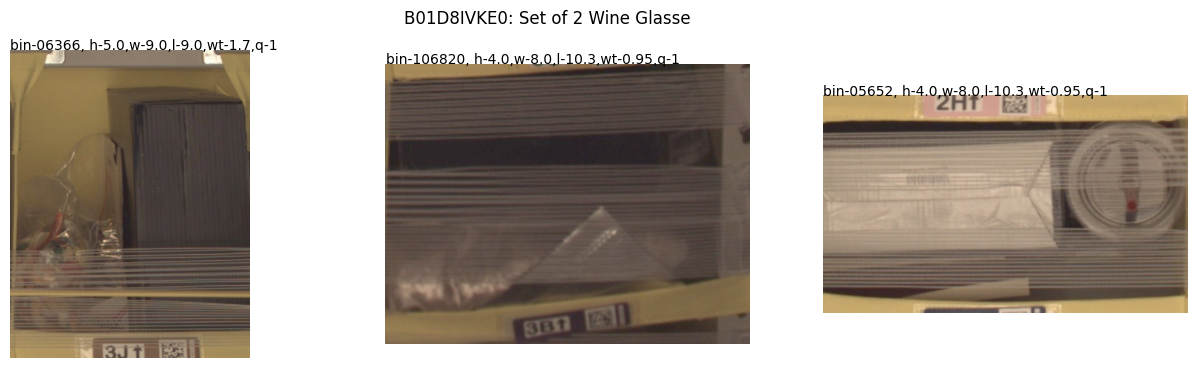

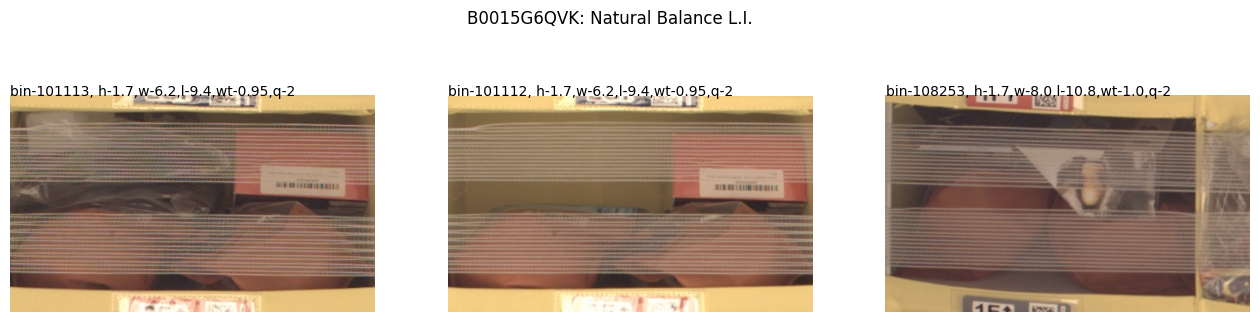

In [12]:
from matplotlib import pyplot as plt
from binsense.config import BIN_DOWNLOAD_DIR

import os

BIN_IMAGES_DIR = os.path.join(BIN_DOWNLOAD_DIR, 'images')


def show_sample(df, item_id, item_attrs):
    attrs = ['item_id', 'bin_id', 'item_name']
    attrs.extend(item_attrs.keys())
    disp_df = df[df.item_id == item_id][attrs]
    disp_df = disp_df.sort_values(by="item_id").reset_index(drop=True)
    
    def format(value):
        if isinstance(value, float):
            return round(value, 2)
        return value

    cols = len(disp_df)
    fig, axs = plt.subplots(1, cols, figsize=(16,4))
    for c in range(cols):
        # show images row
        img = Image.open(os.path.join(BIN_IMAGES_DIR, f'{disp_df["bin_id"][c]}.jpg'))
        axs[c].imshow(img, cmap = plt.cm.Spectral)
        axs[c].set_axis_off()
        
        title = ",".join([ f'{item_attrs[k]}-{format(disp_df[k][c])}' for k in item_attrs.keys() ])
        axs[c].text(0, 0, f'bin-{disp_df["bin_id"][c]}, {title}', wrap=True)

    fig.suptitle(f"{disp_df['item_id'][c]}: {disp_df['item_name'][c][0:20]}")
    plt.show(block=True)

df = item_df.groupby(['item_id'])['bin_id'].count()\
            .reset_index(name="bins")
df = df.merge(item_df, how="inner", on="item_id")\
        .reset_index(drop=True)\
        .sort_values(by="item_id").reset_index(drop=True)

nqty = df[df["bins"] > 1].groupby("item_id")["item_qty"].nunique()
nqty = nqty[nqty > 1]
print("items with different qty in bins ", len(nqty))
for x in nqty.sample(2).index:
    show_sample(item_df, x, {'item_qty': 'q'})

df["item_weight"] = df["item_weight"].round(2)
nweight = df[df["bins"] > 1].groupby("item_id")["item_weight"].nunique()
nweight = nweight[nweight > 1]
print("items with different weight in bins ", len(nweight))
for x in nweight.sample(2).index:
    show_sample(item_df, x, {'item_weight': 'wt',  
                             'item_width': 'w', 
                             'item_length': 'l', 
                             'item_height': 'h', 
                             'item_qty': 'q'})

df["item_height"] = df["item_height"].round(2)
nheight = df[df["bins"] > 1].groupby("item_id")["item_height"].nunique()
nheight = nheight[nheight > 1]
print("items with different height in bins ", len(nheight))
for x in nweight.sample(3).index:
    show_sample(item_df, x, {'item_height': 'h', 
                             'item_width': 'w', 
                             'item_length': 'l', 
                             'item_weight': 'wt', 
                             'item_qty': 'q'})

In [13]:
item_df[item_df["item_id"] == "B0030UF6EW"]

bin_id     item_id                                          item_name  \
3240   02921  B0030UF6EW  Aveeno Baby Daily Moisture Lotion, Fragrance F...   
4559   05292  B0030UF6EW  Aveeno Baby Daily Moisture Lotion, Fragrance F...   
5311   07214  B0030UF6EW  Aveeno Baby Daily Moisture Lotion, Fragrance F...   
6127  104734  B0030UF6EW  Aveeno Baby Daily Moisture Lotion, Fragrance F...   
7261   07215  B0030UF6EW  Aveeno Baby Daily Moisture Lotion, Fragrance F...   
9735  104733  B0030UF6EW  Aveeno Baby Daily Moisture Lotion, Fragrance F...   

      item_qty  item_length item_length_unit  item_width item_width_unit  \
3240         3          9.5               IN        3.75              IN   
4559         1          9.9               IN        2.70              IN   
5311         1          9.5               IN        3.75              IN   
6127         3          9.5               IN        3.75              IN   
7261         1          9.5               IN        3.75              IN   
9735         3          9.5               IN        3.75              IN   

      item_height item_height_unit  item_weight item_weight_unit  
3240          1.9               IN          1.3           pounds  
4559          1.8               IN          1.1           pounds  
5311          1.9               IN          1.3           pounds  
6127          1.9               IN          1.3           pounds  
7261          1.9               IN          1.3           pounds  
9735          1.9               IN          1.3           pounds

In [27]:
bin_classes = item_df.groupby('bin_id')['item_id'].nunique().reset_index(name="classes")
df = bin_df.merge(bin_classes, on="bin_id", how="left")
df = df[df['classes'] < 2]
df = df[ df['bin_image_kb'].between(40, 100) ]
df.sort_values(by="classes", ascending=False, inplace=True)
df = df[0:30]
print(len(df), item_df[item_df.bin_id.isin(df['bin_id'])]['item_id'].nunique())
print(df['bin_id'].to_list())

30 30
['08215', '106968', '09769', '101999', '108604', '104060', '10972', '10071', '111389', '113926', '04511', '106196', '02754', '11178', '100280', '01748', '05087', '112602', '109275', '103896', '02017', '106856', '00084', '105811', '104979', '100198', '113999', '112808', '02021', '06259']


In [268]:
# transpose bin
item_bin_transpose_df = item_df.groupby('item_id')['bin_id']\
            .apply(lambda df: df.reset_index(drop=True))\
            .unstack()\
            .reset_index()\
            .rename(columns={i : f'bin_{i+1}' for i in range(0, 13)})

item_bincount_df = item_df.groupby(['item_id'])['bin_id'].count()\
            .reset_index(name="bins")

df = item_df.drop(['bin_id'], axis=1)\
        .merge(item_bin_transpose_df, how="inner", on="item_id")\
        .reset_index(drop=True)\
        .merge(item_bincount_df, how="inner", on="item_id")\
        .sort_values(by="item_id")\
        .reset_index(drop=True)

item_flat_df = df
del df
del item_bin_transpose_df
del item_bincount_df

item_flat_df.head()
# item_across_bins_df =  item_df[item_df.item_id.isin(df[df['bins']> 2]['item_id'])].sort_values(by='item_id')
# item_across_bins_df[['bin_id', 'item_name']]


item_id                                          item_name  item_qty  \
0  0002624028  THE KREMLIN'S DILEMMA: The Struggle for Human ...         1   
1  0061986623                Another Summer: A Beach House Novel         1   
2  0062080644  Super Immunity: The Essential Nutrition Guide ...         3   
3  0062080644  Super Immunity: The Essential Nutrition Guide ...         3   
4  0062111736                     Folly Beach: A Lowcountry Tale         1   

   item_length item_length_unit  item_width item_width_unit  item_height  \
0     8.267717               IN    5.669291              IN     1.496063   
1     7.900000               IN    5.200000              IN     1.100000   
2     7.795276               IN    5.196850              IN     0.866142   
3     7.795276               IN    5.196850              IN     0.866142   
4     7.900000               IN    5.300000              IN     1.200000   

  item_height_unit  item_weight  ... bin_5 bin_6 bin_7 bin_8 bin_9 bin_10  \
0               IN     1.190000  ...   NaN   NaN   NaN   NaN   NaN    NaN   
1               IN     0.950000  ...   NaN   NaN   NaN   NaN   NaN    NaN   
2               IN     0.485012  ...   NaN   NaN   NaN   NaN   NaN    NaN   
3               IN     0.485012  ...   NaN   NaN   NaN   NaN   NaN    NaN   
4               IN     0.550000  ...   NaN   NaN   NaN   NaN   NaN    NaN   

  bin_11 bin_12 bin_13 bins  
0    NaN    NaN    NaN    1  
1    NaN    NaN    NaN    1  
2    NaN    NaN    NaN    2  
3    NaN    NaN    NaN    2  
4    NaN    NaN    NaN    1  

[5 rows x 25 columns]

array([[<Axes: title={'center': 'bin_image_kb'}>]], dtype=object)

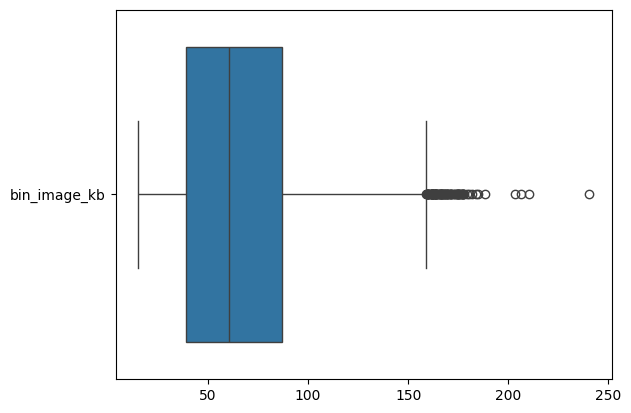

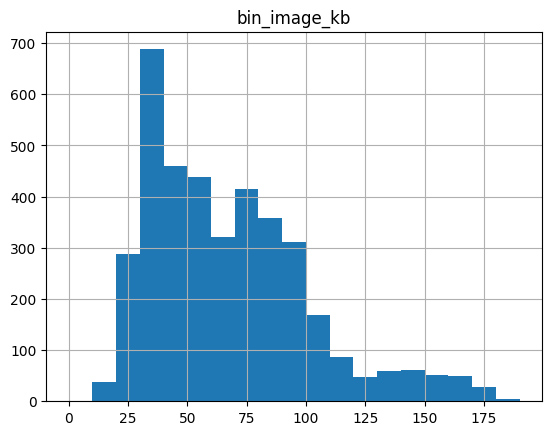

In [11]:
import seaborn as sns
sns.boxplot(bin_df[['bin_image_kb']], orient='h')
bin_df[['bin_image_kb']].hist(bins=range(0, 200, 10))

array([[<Axes: title={'center': 'bin_qty'}>]], dtype=object)

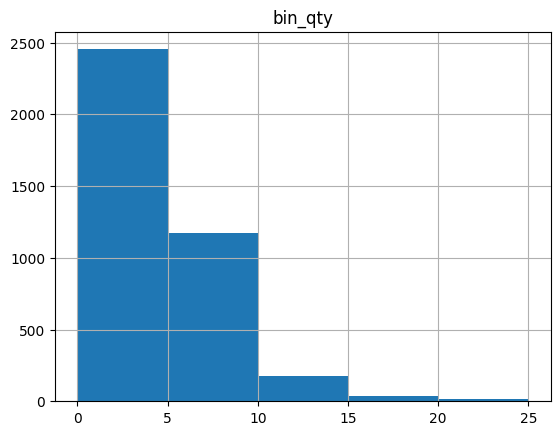

In [12]:
bin_df[['bin_qty']].hist(bins=range(0, 30, 5))

In [273]:
from PIL import Image
from matplotlib import pyplot as plt

bin_itemcls_df = item_df.groupby(['bin_id'])['item_id'].count().reset_index(name="item_classes")
bin_itemcls_df = bin_df.merge(bin_itemcls_df, on='bin_id', how="left", copy=False, validate='1:1')


def plot_sample(df, filter, title, samples=6):
    df_sample = df[filter].sample(n=6).reset_index()
    df_sample['image_path'] = [os.path.join(BIN_DOWNLOAD_DIR, 'images', n) for n in df_sample['bin_image_name']]

    i = 0
    fig, axs = plt.subplots(3, 2, figsize=(16,16))
    for r in range(3):
        for c in range(2):
            img = Image.open(df_sample['image_path'][i])
            img_title = f'bin={df_sample["bin_id"][i]},size={df_sample["bin_image_kb"][i]}kb,qty={df_sample["bin_qty"][i]},#itemcls={df_sample["item_classes"][i]}'

            axs[r][c].imshow(img, cmap = plt.cm.Spectral)
            axs[r][c].set_axis_off()
            axs[r][c].set_title(img_title)
            i += 1

    fig.suptitle(title)
    plt.show(block=True)

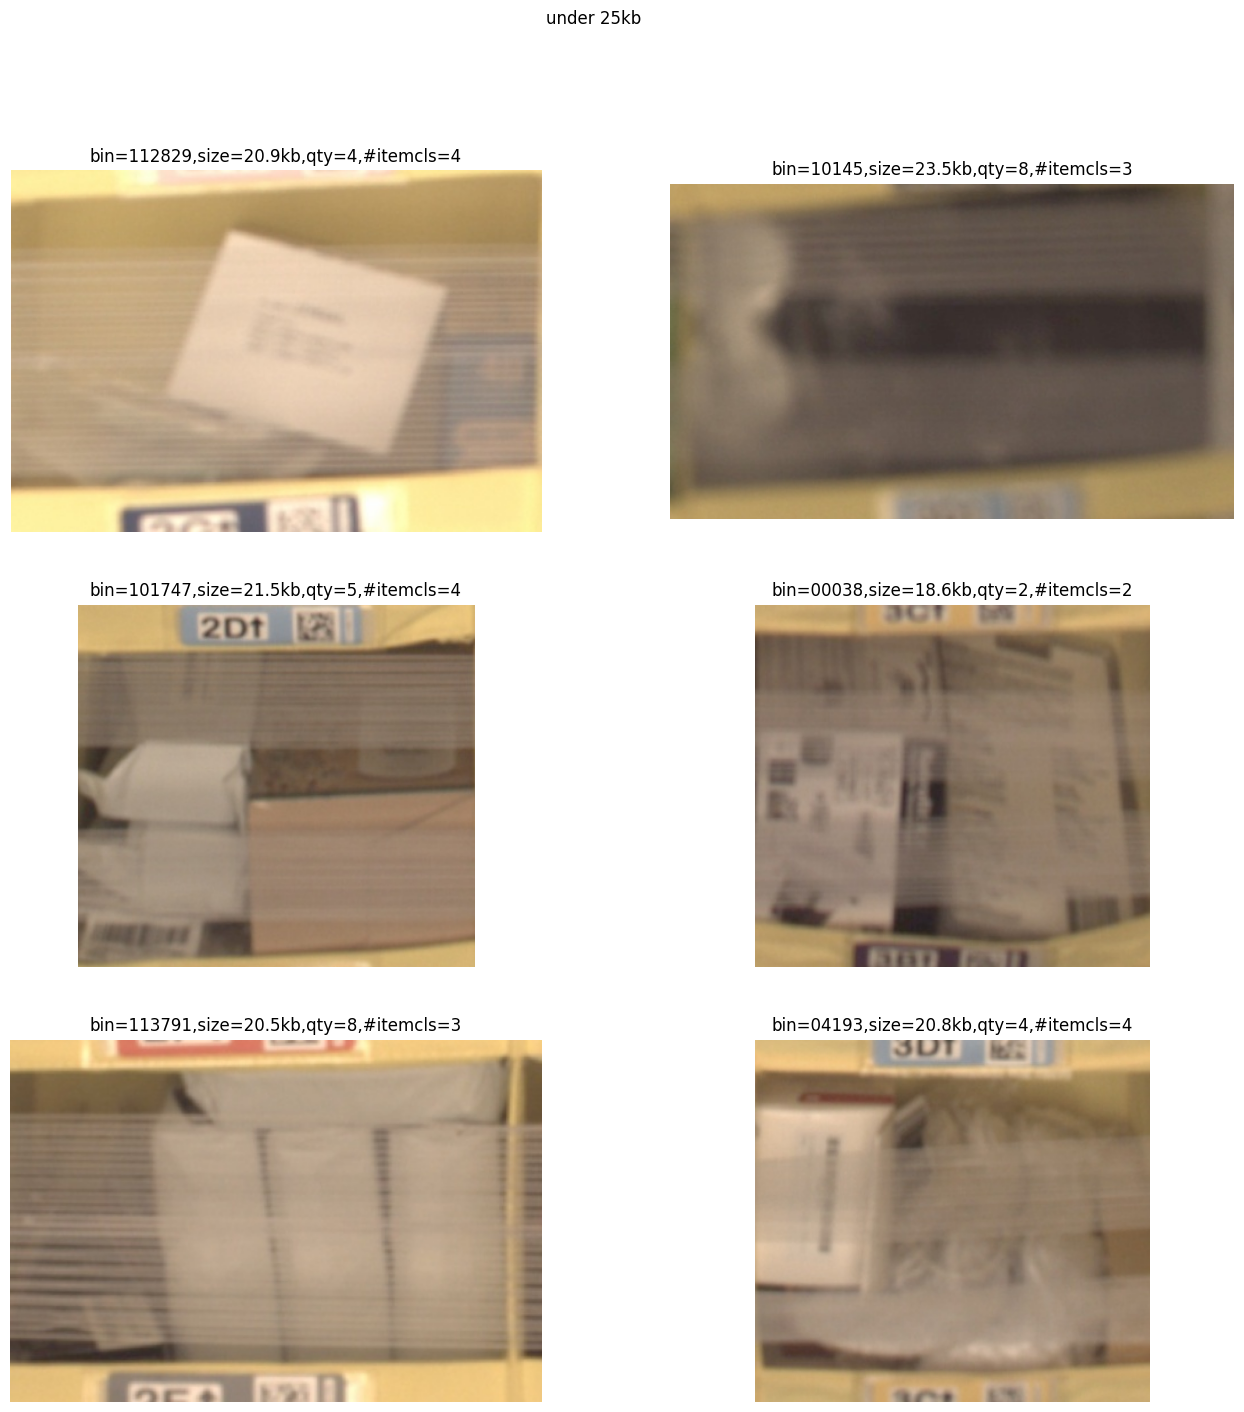

In [274]:
plot_sample(bin_itemcls_df, 
            bin_itemcls_df['bin_image_kb'] < 25, 
            'under 25kb')

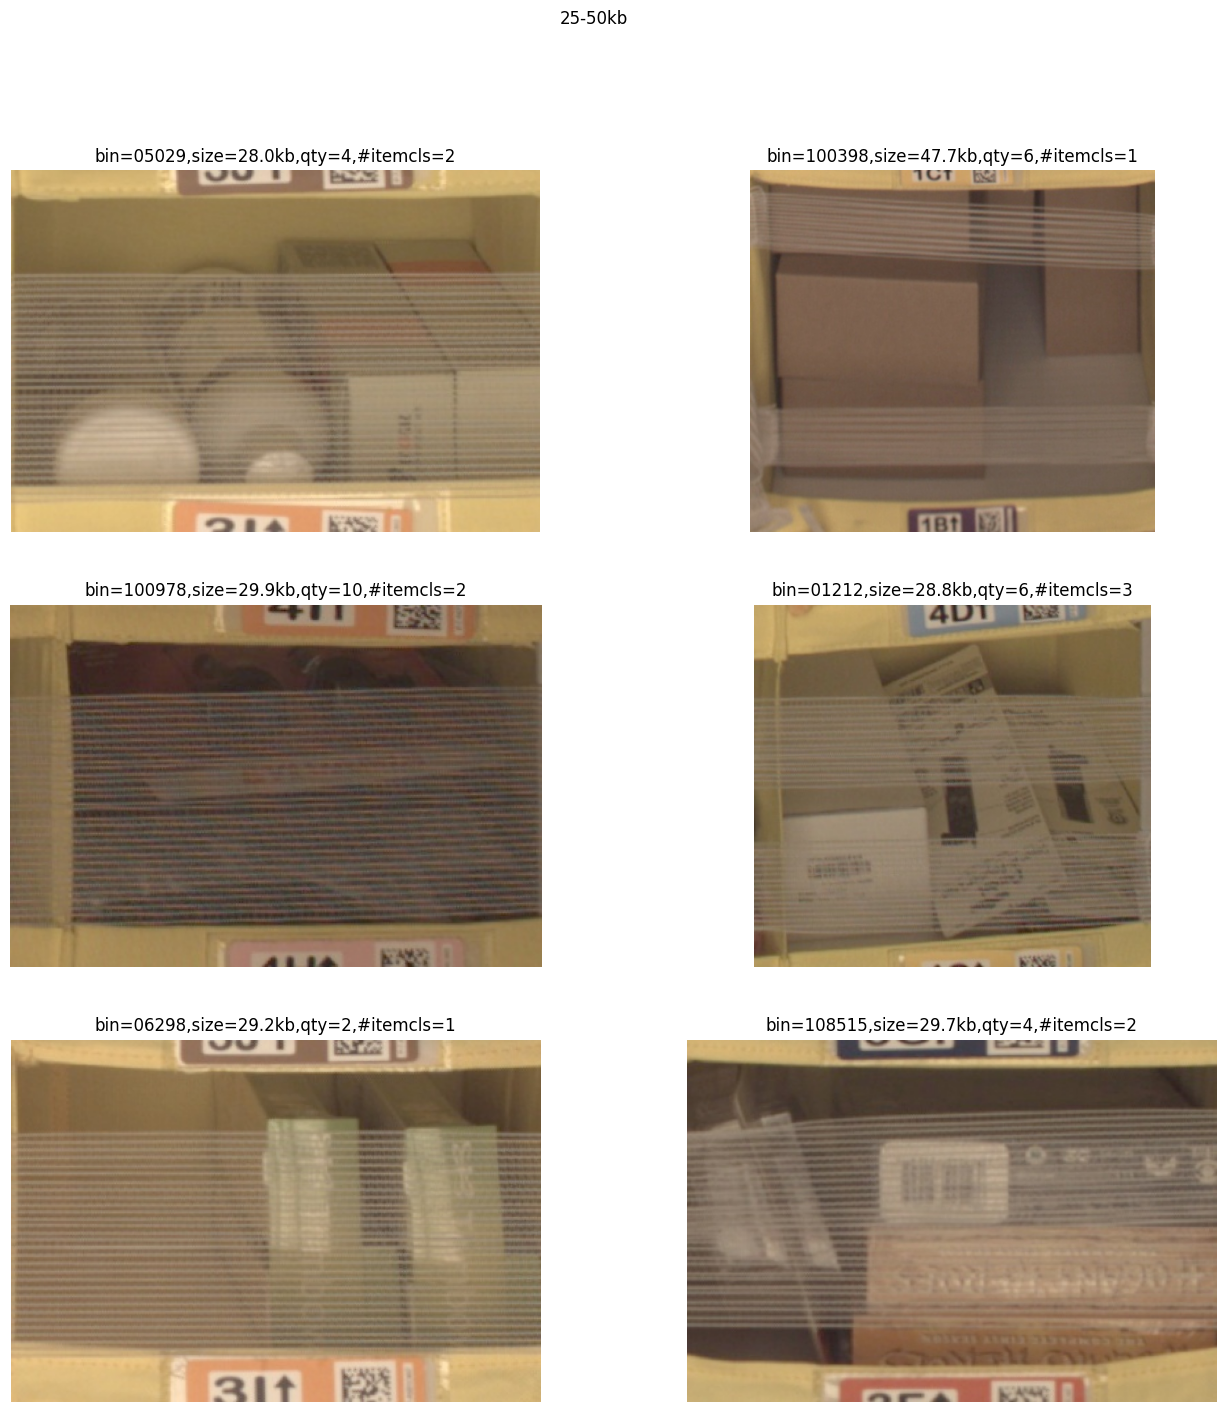

In [275]:
plot_sample(bin_itemcls_df, 
            (bin_itemcls_df['bin_image_kb'] >= 25) & \
                (bin_itemcls_df['bin_image_kb'] < 50), 
            '25-50kb')

In [1]:
plot_sample(bin_itemcls_df, 
            (bin_itemcls_df['bin_image_kb'] >= 50) & \
                (bin_itemcls_df['bin_image_kb'] < 75), 
            '50-75kb')

NameError: name 'plot_sample' is not defined

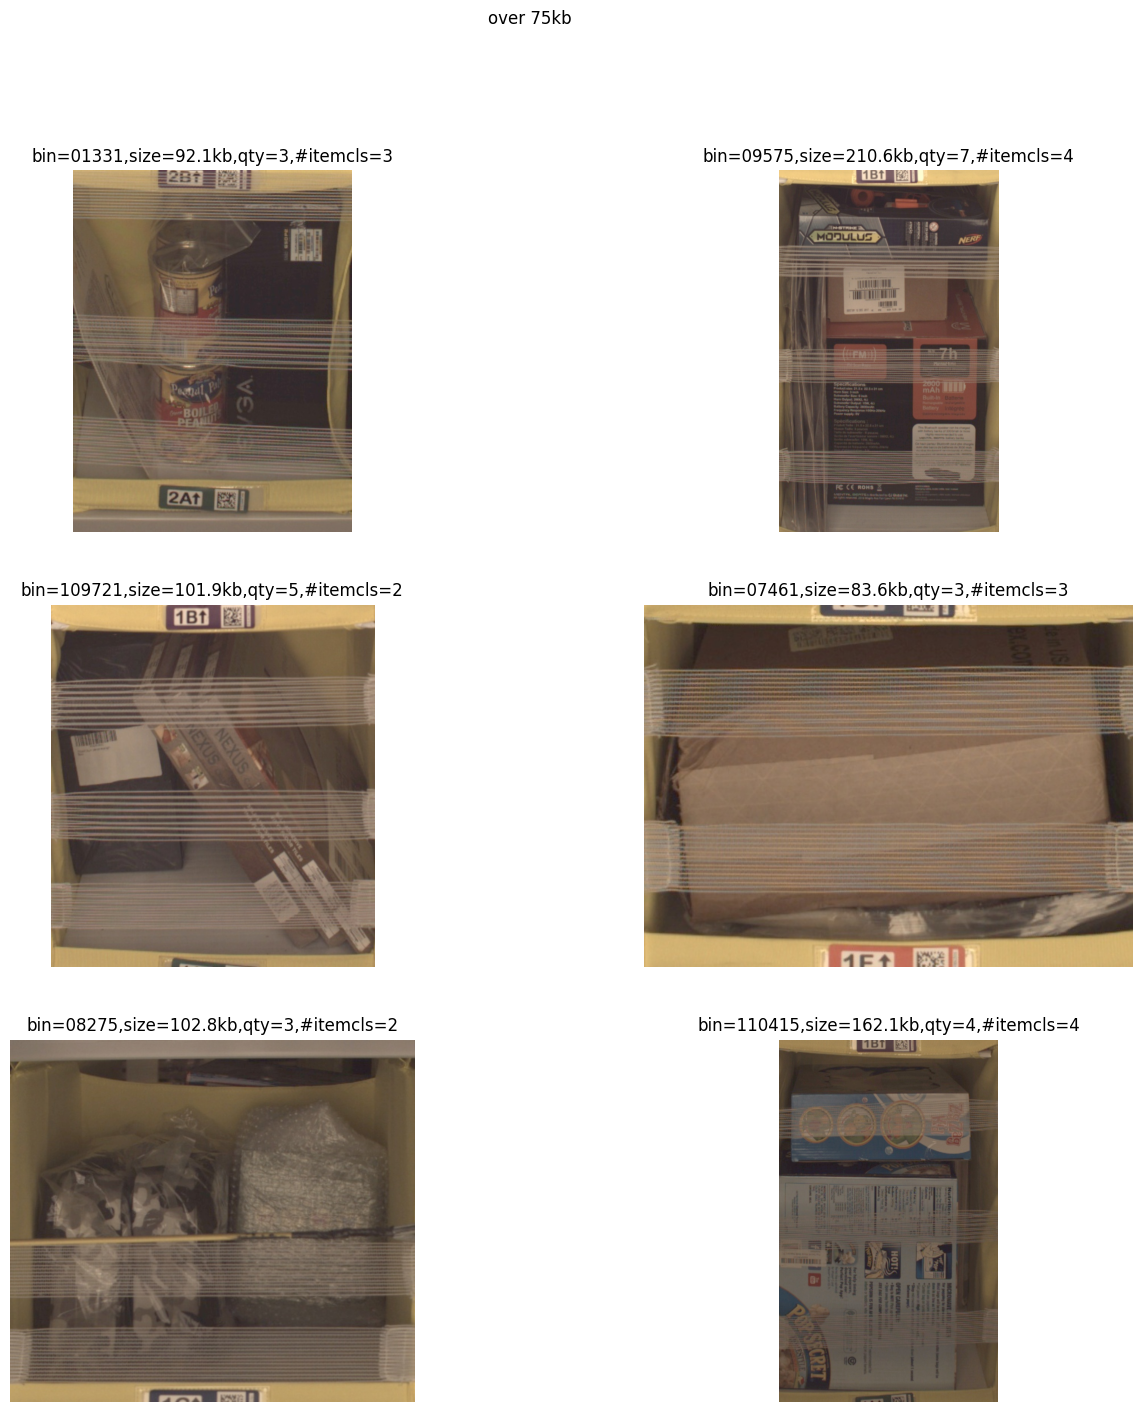

In [277]:
plot_sample(bin_itemcls_df, 
            (bin_itemcls_df['bin_image_kb'] >75), 
            'over 75kb')

(Morphology) https://docs.opencv.org/4.x/dd/dd7/tutorial_morph_lines_detection.html
(Morphological Transformations) https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html
(Canny Edge) https://docs.opencv.org/4.x/d7/de1/tutorial_js_canny.html
(Adaptive Thresholding) https://homepages.inf.ed.ac.uk/rbf/HIPR2/adpthrsh.htm, https://docs.opencv.org/4.x/d7/dd0/tutorial_js_thresholding.html#
https://stackoverflow.com/questions/71425968/remove-horizontal-lines-with-open-cv

src /Users/n0c09jf/code/github/tryml/projects/binsense/_data/s3/images/109617.jpg


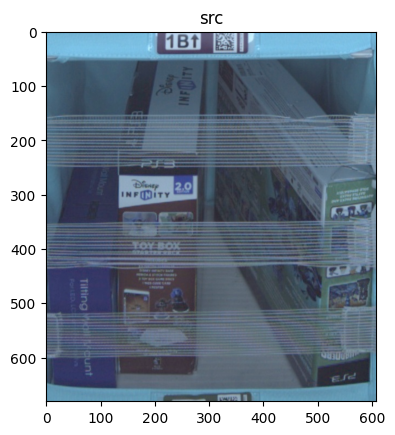

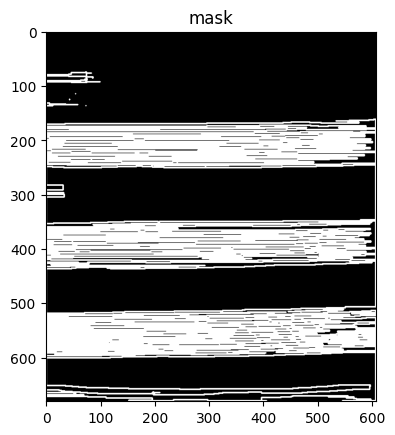

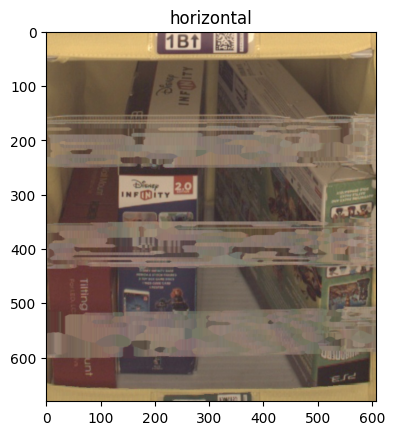

In [115]:
import numpy as np
import cv2 as cv

from matplotlib import pyplot as plt

def show_img(title, cv_img):
    plt.imshow(cv.cvtColor(cv_img, cv.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

def grap_pixels_in_countor(img, cnt):
    cimg = np.zeros_like(img)
    cv.drawContours(cimg, [cnt], 0, color=255, thickness=cv.FILLED)
    
    # Access the image pixels and create a 1D numpy array then add to list
    pts = np.where(cimg == 255)
    return img[pts[0], pts[1]], pts

def mean_color(pixels):
    return np.round(np.mean(pixels, axis=0), 0)

def dominant_color(pixels):
    data = np.float32(pixels)
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    flags = cv.KMEANS_RANDOM_CENTERS
    _,_,centers = cv.kmeans(data,K=1,bestLabels=None,criteria=criteria,attempts=10,flags=flags)
    
    return centers[0].astype(np.int32)

def blend_contour_color(img, pixel_locs_cnts):
    img_copy = np.copy(img)
    img_copy = img_copy / 255
    for cnt in pixel_locs_cnts:
        img_copy[cnt[0], cnt[1]] = np.nan
    
    def nangaussian(U, sigma=1, truncate=4.0):
        V = U.copy()
        V[np.isnan(U)] = 0
        # VV = cv.GaussianBlur(U, (21, 21), 10.0)
        VV = skimage.filters.gaussian(V, sigma=sigma, truncate=truncate, preserve_range=True)
        
        W = 0*U.copy()+1
        W[np.isnan(U)] = 0
        # WW = cv.GaussianBlur(U, (21,21), 10.0)
        WW = skimage.filters.gaussian(W, sigma=sigma, truncate=truncate, preserve_range=True)
        return VV / WW
    smooth = nangaussian(img_copy, sigma=1, truncate=4.0)
    
    # do not smooth full image but only copy smoothed NaN spots
    fill = img.copy()
    for cnt in pixel_locs_cnts:
        fill[cnt[0], cnt[1]] = (smooth[cnt[0], cnt[1]] * 255).astype(np.uint8)
    return fill

df_sample = bin_df[bin_df['bin_image_kb'] >75].sample(n=1)
df_sample['image_path'] = [os.path.join(BIN_DOWNLOAD_DIR, 'images', n) for n in df_sample['bin_image_name']]

img_path = df_sample.iloc[0]['image_path']
img_path = '/Users/n0c09jf/code/github/tryml/projects/binsense/_data/s3/images/109617.jpg'
print("src", img_path)

src = cv.imread(img_path, cv.IMREAD_COLOR)
show_img("src", cv.cvtColor(src, cv.COLOR_BGR2RGB))

# print('src shape:', src.shape)
gray = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
# print('gray shape:', src.shape)
# show_img("gray", cv.cvtColor(gray, cv.COLOR_BGR2RGB))


# Apply adaptiveThreshold at the bitwise_not of gray, notice the ~ symbol
gray = cv.bitwise_not(gray)
bw = cv.adaptiveThreshold(
    gray, 255, cv.ADAPTIVE_THRESH_MEAN_C,
    cv.THRESH_BINARY, 15, -2)
# show_img("bw", cv.cvtColor(bw, cv.COLOR_BGR2RGB))

horizontal = np.copy(bw)
cols = horizontal.shape[1]
horizontal_size = cols // 30
# Create structure element for extracting horizontal lines through morphology operations
horizontalStructure = cv.getStructuringElement(cv.MORPH_RECT, (horizontal_size, 1))
# # Apply morphology operations
# horizontal = cv.erode(horizontal, horizontalStructure)
# horizontal = cv.dilate(horizontal, horizontalStructure)
# show_img("horizontal", cv.cvtColor(horizontal, cv.COLOR_BGR2RGB))

detected_lines = cv.morphologyEx(horizontal, cv.MORPH_CLOSE, horizontalStructure, iterations=3)
cnts, _ = cv.findContours(detected_lines, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
# print(len(cnts), cnts[0].shape)
cnt_img = np.copy(src)
cnt1_img = np.copy(src)
mask = np.zeros(gray.shape, np.uint8)
colors = []
pixel_locs_cnts = []
for i, c in enumerate(cnts):
    in_cnt_pixels, cnt_pixel_locs = grap_pixels_in_countor(src, c)
    dcolor = dominant_color(in_cnt_pixels)
    mcolor = mean_color(in_cnt_pixels)
    colors.append(np.array(mcolor))
    pixel_locs_cnts.append(cnt_pixel_locs)
    #print("top color:", dcolor, ", mean color:", mcolor)
    if mcolor[0] in range(60, 100) and mcolor[1] in range(70, 110) and mcolor[2] in range(90, 130):
        cv.drawContours(cnt_img, [c], -1, (255,255,255), 2)
        cv.drawContours(mask, [c], -1, (255,255,255), 2)
        
    cv.drawContours(cnt1_img, [c], -1, (255,255,255), 2)
    
show_img("mask", mask)
# show_img("horizontal", cnt_img)
# show_img("horizontal", cnt1_img)
f_img = cv.inpaint(src, mask, 0.5, cv.INPAINT_NS)
# f_img = blend_contour_color(src, pixel_locs_cnts)
show_img("horizontal", f_img)

# colors = np.array(colors)
# print(np.min(colors, axis=0), np.max(colors, axis=0))


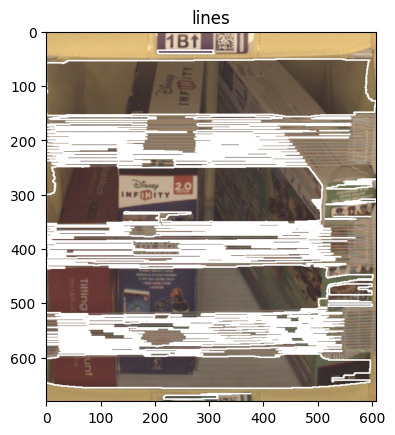

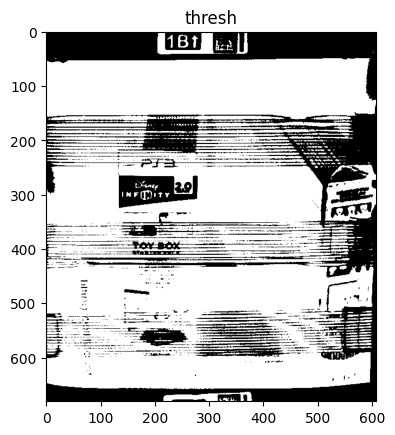

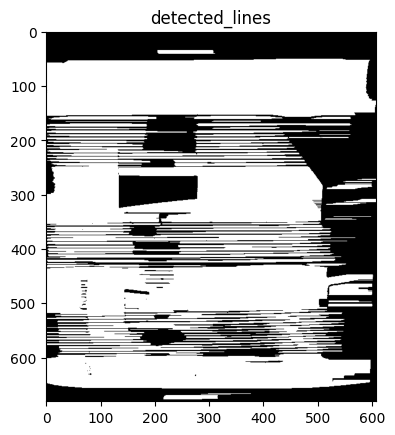

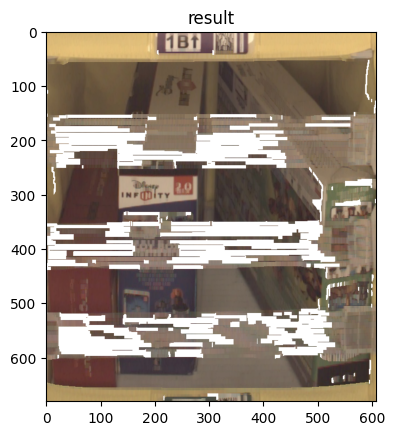

In [30]:
import cv2

img_path = '/Users/n0c09jf/code/github/tryml/projects/binsense/_data/s3/images/109617.jpg'

image = cv2.imread(img_path)
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Remove horizontal
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25,1))
detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(image, [c], -1, (255,255,255), 2)
show_img('lines', image)

# Repair image
repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,6))
result = 255 - cv2.morphologyEx(255 - image, cv2.MORPH_CLOSE, repair_kernel, iterations=1)

show_img('thresh', thresh)
show_img('detected_lines', detected_lines)
show_img('result', result)